/Users/Sam/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/Sam/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


                       start       end  hnM_DMSO   hnM_TAM  hnM_DMSO_1  \
start               1.000000  1.000000 -0.003897 -0.002235   -0.003897   
end                 1.000000  1.000000 -0.003897 -0.002235   -0.003897   
hnM_DMSO           -0.003897 -0.003897  1.000000  0.813531    1.000000   
hnM_TAM            -0.002235 -0.002235  0.813531  1.000000    0.813531   
hnM_DMSO_1         -0.003897 -0.003897  1.000000  0.813531    1.000000   
hnM_TAM_1          -0.002235 -0.002235  0.813531  1.000000    0.813531   
log2ratio_TAM-DMSO  0.014556  0.014556 -0.092806  0.090004   -0.092806   

                    hnM_TAM_1  log2ratio_TAM-DMSO  
start               -0.002235            0.014556  
end                 -0.002235            0.014556  
hnM_DMSO             0.813531           -0.092806  
hnM_TAM              1.000000            0.090004  
hnM_DMSO_1           0.813531           -0.092806  
hnM_TAM_1            1.000000            0.090004  
log2ratio_TAM-DMSO   0.090004            1.

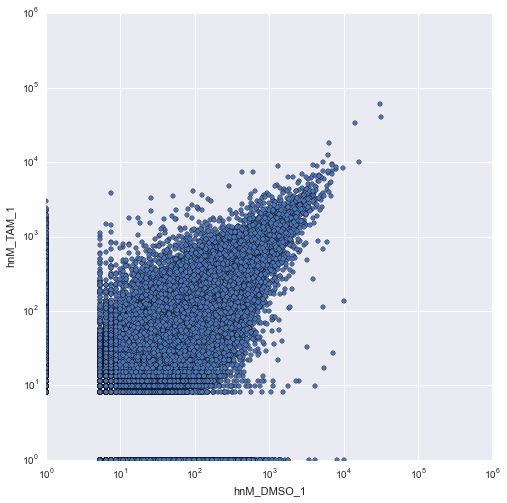

In [1]:
#The purpose of this is to write a script to generate normalized reads in each sample based on total library size
#and then print this out to a normalized file

#Then the script will overlap the RT stops within a user defined region (i.e.50 bp) to generate clusters of RT stops

#Also the script will plot the normalized data before 

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
%matplotlib inline
#first, convert the centercoord.bw file to a bedgraph file
os.system("bigWigToBedGraph hnM_DMSO_files/HS_hnRNPM_DMSO_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved_CLIP_clusters_lowFDRreads_centerCoord.bw hnM_DMSO.bg")
os.system("bigWigToBedGraph hnM_TAM_files/HS_hnRNPM_TAM_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved_CLIP_clusters_lowFDRreads_centerCoord.bw hnM_TAM.bg")
#Then load these files into dataframes
DMSO_df = pd.read_csv('hnM_DMSO.bg',sep='\t',header = None,names = ['chrom','start','end','RT_stops'])
TAM_df = pd.read_csv('hnM_TAM.bg',sep='\t',header = None,names = ['chrom','start','end','RT_stops'])
#make a dataframe list
df_list = [DMSO_df,TAM_df]
#now calculate and store the total number of RT stops as a scalar to divide by and then multiply
for df in df_list:
    total_reads = df.RT_stops.sum()
    df.RT_stops = df.RT_stops.mul(1e7/total_reads)
#save the dataframes as bedgraphs
file_names = ['hnM_DMSO','hnM_TAM']
counter = 0
for df in df_list:
    df.to_csv(file_names[counter]+'_normalized.bg',sep='\t',index = False,header = False)
    counter += 1
#now use pybedtools to make a bedtool out of each of these. don't loop just take the files in
DMSO_bt = pbt.BedTool(fn='hnM_DMSO_normalized.bg')
TAM_bt = pbt.BedTool(fn='hnM_TAM_normalized.bg')
#now merge together into new clusters based on 20 nucleotides (This is what the Black RbFox paper did)
#Make sure to sum the bedgraph quantity column
DMSO_bt_merge = DMSO_bt.merge(d=20,c=4,o='sum').saveas('hnM_DMSO_normalized_merge20.bg')
TAM_bt_merge = TAM_bt.merge(d=20,c=4,o='sum').saveas('hnM_TAM_normalized_merge20.bg')
#now overlap the different samples. Black Rbfox paper took intersecting clusters and compared the read count between
#only those that intersected. There was no information about the clusters that did not intersect. 

#now I need to merge the DMSO and TAM merged clusters so that I can have a common set of clusters
#To do this, concat together the merges and then remerge but do not have a d
DMSO_TAM_bt_combined = DMSO_bt_merge.cat(TAM_bt_merge).saveas("hnM_DMSO_TAM_merge.bed")

#now just add a column of 0s to the merge_outfile

with open('hnM_DMSO_TAM_merge.bed') as infile:
    inlist = infile.readlines()
    outlist = []
    for line in inlist:
        line = line.strip()
        line +='\t0\n'
        outlist.append(line)
    with open('hnM_DMSO_TAM_merge_with_0','w') as outfile:
        for line in outlist:
            outfile.write(line)
            
DMSO_TAM_bt_combined_with_0 = pbt.BedTool(fn='hnM_DMSO_TAM_merge_with_0')

#Now that I have the merged clusters as a bedfile, concatenate it with each sample and then merge. Converg these to 
DMSO_bt_merge_cat_DMSO_TAM_bt_combined_with_0 = DMSO_bt_merge.cat(DMSO_TAM_bt_combined_with_0,postmerge=False).sort()
DMSO_bt_merge_final = DMSO_bt_merge_cat_DMSO_TAM_bt_combined_with_0.merge(c=4,o='sum').saveas("hnM_DMSO_merge_final.bg")
pbt.contrib.bigwig.bedgraph_to_bigwig(DMSO_bt_merge_final,genome='hg19',output='hnM_DMSO_merge_final.bw')

TAM_bt_merge_cat_DMSO_TAM_bt_combined_with_0 = TAM_bt_merge.cat(DMSO_TAM_bt_combined_with_0,postmerge=False).sort()
TAM_bt_merge_final = TAM_bt_merge_cat_DMSO_TAM_bt_combined_with_0.merge(c=4,o='sum').saveas("hnM_TAM_merge_final.bg")
pbt.contrib.bigwig.bedgraph_to_bigwig(TAM_bt_merge_final,genome='hg19',output='hnM_TAM_merge_final.bw')

#Now overlap into a common unionbedg
cmd = 'bedtools unionbedg -i hnM_DMSO_merge_final.bg hnM_TAM_merge_final.bg > hnM_DMSO_TAM_merge_final_union.bg'
os.system(cmd)

#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples
header_list=['chrom','start','end','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_merge_final_union.bg',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+1,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+1,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+1,2)-log(row['hnM_DMSO']+1,2)),axis=1)

#Plot in Matplotlib and compute pearson correlation coefficient
ax = hnM_DMSO_TAM_final_union_df.plot(kind='scatter',x='hnM_DMSO_1',y='hnM_TAM_1',figsize=(8,8),loglog=True,\
                                 xlim=(1,10e5),ylim=(1,10e5))

#compute pearson correlation between each column
print(hnM_DMSO_TAM_final_union_df.corr())

In [2]:
hnM_DMSO_TAM_final_union_df.describe()

,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO
count,1.909380e+05,1.909380e+05,190938.000000,190938.000000,190938.000000,190938.000000,190938.000000
mean,8.009591e+07,8.009593e+07,52.373022,52.373022,53.373022,53.373022,-0.162090
std,5.663029e+07,5.663029e+07,215.131628,272.204364,215.131628,272.204364,3.784907
min,4.466900e+04,4.467000e+04,0.000000,0.000000,1.000000,1.000000,-13.318714
25%,3.535694e+07,3.535694e+07,0.000000,0.000000,1.000000,1.000000,-3.113815
50%,6.966486e+07,6.966486e+07,8.750502,10.561930,9.750502,11.561930,-0.339245
75%,1.150011e+08,1.150012e+08,40.471070,35.206433,41.471070,36.206433,3.531310
max,2.491478e+08,2.491478e+08,31872.608450,60588.510730,31873.608450,60589.510730,11.542541


In [8]:
#Try correlating the bedgraphs with deeptools
#First step = make the BigwigSummary over the bed file containing the regions the peaks are in
cmd = 'multiBigwigSummary BED-file -b hnM_DMSO_merge_final.bw hnM_TAM_merge_final.bw -out hnM_DMSO_TAM_results.npz --BED hnM_DMSO_TAM_merge.bed'
os.system(cmd)

256

In [119]:
#now use deeptools plotCorrelation - Note, this is not that impressive. Use matplotlib
cmd = 'plotCorrelation --corData hnM_DMSO_TAM_results.npz --plotFile hnM_DMSO_TAM_correlation.png --corMethod pearson -p \
scatterplot --plotTitle "Correlation between hnM DMSO and TAM" --outFileCorMatrix hnM_DMSO_TAM_pearson_scores.tab'
os.system(cmd)

0

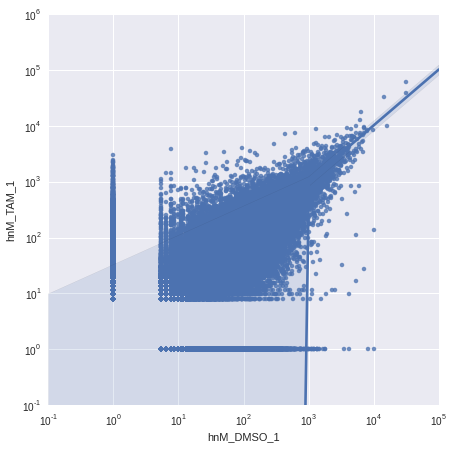

In [214]:
#set up matplotlib axes for the seaborn regression plot
f,ax = plt.subplots(figsize=(7,7))
ax.set(xscale='log',yscale='log')
sns.regplot("hnM_DMSO_1","hnM_TAM_1",hnM_DMSO_TAM_final_union_df,ax=ax)

[]